In this notebook, we are looking for gaps in the audio data collected by two badges - one with an old firmware, and one with the new firmware (2.0)

New badge (firmware 2.0) - C7:75:13:05:10:EE

Old badge - F9:4A:86:6E:F4:0C

In [1]:
from __future__ import absolute_import, division, print_function

import os
import sys
import datetime
import pandas as pd
import numpy as np
import pytz
import dateutil
import gzip

from ggplot import *
%matplotlib inline

# add the 'src' directory as one where we can import modules
src_dir = os.path.join(os.getcwd(), os.pardir, os.pardir)
sys.path.append(src_dir)

# import data analysis modules
import openbadge_analysis as ob

In [2]:
# Load the "autoreload" extension
%load_ext autoreload
# always reload modules marked with "%aimport"
%autoreload 1
# list of modules to autoload
%aimport openbadge_analysis

In [3]:
# config
filename = '/home/orenled/temp/logs/3_log_audio.txt.gz'
log_filename = '/home/orenled/temp/logs/3_server.log.gz'

eastern = pytz.timezone('US/Eastern')
utc  = pytz.timezone('UTC')

# Find badge first reset

If we want to get a real sense of how many gaps we have, we need to discard data after the the badges stared to reset. We need to look at the actualy logfile to find that time. This isn't going to be pretty, but it will work.

In [4]:
with gzip.open(log_filename, 'r') as f:
    unsync_raw = [ line for line in f if 'unsync' in line]

In [5]:
import re
# use regex to get date and badge
unsync_split = [ re.match('(.*) - INFO - \[(.*)\]',line).group(1,2) for line in unsync_raw]

In [6]:
# load into a dataframe and convert the date
df_log = pd.DataFrame(unsync_split,columns=['datetime','badge_address'])
print(df_log.head())
print(df_log['datetime'].head())

                  datetime      badge_address
0  2016-12-27 11:51:55,113  C7:75:13:05:10:EE
1  2016-12-27 11:51:58,390  F9:4A:86:6E:F4:0C
2  2016-12-30 09:45:36,636  F9:4A:86:6E:F4:0C
3  2016-12-30 10:16:56,960  F9:4A:86:6E:F4:0C
4  2016-12-30 10:47:39,001  F9:4A:86:6E:F4:0C
0    2016-12-27 11:51:55,113
1    2016-12-27 11:51:58,390
2    2016-12-30 09:45:36,636
3    2016-12-30 10:16:56,960
4    2016-12-30 10:47:39,001
Name: datetime, dtype: object


In [7]:
df_log['datetime'] = pd.to_datetime(df_log['datetime'], utc=True)
df_log.sort_values('datetime')
df_log.index = pd.to_datetime(df_log.pop('datetime'), utc=True)

# this log is in EST
df_log = df_log.tz_localize(eastern)
print(df_log.head())
print(df_log.index.dtype)

                                      badge_address
datetime                                           
2016-12-27 11:51:55.113000-05:00  C7:75:13:05:10:EE
2016-12-27 11:51:58.390000-05:00  F9:4A:86:6E:F4:0C
2016-12-30 09:45:36.636000-05:00  F9:4A:86:6E:F4:0C
2016-12-30 10:16:56.960000-05:00  F9:4A:86:6E:F4:0C
2016-12-30 10:47:39.001000-05:00  F9:4A:86:6E:F4:0C
datetime64[ns, US/Eastern]


In [8]:
# reseting index, now that we converted the timezone (i'm not sure how to do this more efficiently...)
df_log = df_log.reset_index()
print(df_log.head())
print(df_log.datetime.dtype)

                          datetime      badge_address
0 2016-12-27 11:51:55.113000-05:00  C7:75:13:05:10:EE
1 2016-12-27 11:51:58.390000-05:00  F9:4A:86:6E:F4:0C
2 2016-12-30 09:45:36.636000-05:00  F9:4A:86:6E:F4:0C
3 2016-12-30 10:16:56.960000-05:00  F9:4A:86:6E:F4:0C
4 2016-12-30 10:47:39.001000-05:00  F9:4A:86:6E:F4:0C
datetime64[ns, US/Eastern]


The first reset (for every badge) is the first time we set the clock, so it's not really a reset

In [9]:
df_log_grp = df_log.groupby('badge_address')
start_time = df_log_grp.nth(0)
print("Start time\n",start_time,"\n\n")

first_reset = df_log_grp.nth(1)
print("First reset\n",first_reset,"\n\n")

# change to a more convinient format
first_reset = first_reset.reset_index()
first_reset.rename(columns={'datetime': 'first_reset_datetime'}, inplace=True)
first_reset['first_reset_timestamp'] = first_reset.pop('first_reset_datetime').astype(np.int64)//1e9
print("First reset, restructured\n", first_reset,"\n\n")

Start time
                                           datetime
badge_address                                     
C7:75:13:05:10:EE 2016-12-27 11:51:55.113000-05:00
F9:4A:86:6E:F4:0C 2016-12-27 11:51:58.390000-05:00 


First reset
                                           datetime
badge_address                                     
C7:75:13:05:10:EE 2017-01-02 22:51:17.736000-05:00
F9:4A:86:6E:F4:0C 2016-12-30 09:45:36.636000-05:00 


First reset, restructured
        badge_address  first_reset_timestamp
0  C7:75:13:05:10:EE           1.483415e+09
1  F9:4A:86:6E:F4:0C           1.483109e+09 




# Look for gaps

In [10]:
with gzip.open(filename, 'r') as f:
    audio_chunks = ob.load_audio_chunks_as_json_objects(f, log_version='2.0')

In [11]:
# load data into a data frame
df = pd.DataFrame(audio_chunks,columns=['badge_address','timestamp'])

# Converting timestamp (epoch) to UTC datetime
df['datetime'] = pd.to_datetime(df['timestamp'],unit='s', utc=True)

# Setting datetime as index
df.sort_values('datetime')
df.index = pd.to_datetime(df.pop('datetime'), utc=True)
df = df.tz_localize(utc)
df = df.tz_convert(eastern)
df = df.reset_index() # make it a column again

print(df.head(10))
print(df.dtypes)

                          datetime      badge_address     timestamp
0 2016-12-27 11:51:55.074000-05:00  C7:75:13:05:10:EE  1.482858e+09
1 2016-12-27 11:51:58.399000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
2 2016-12-27 11:51:58.399000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
3 2016-12-27 11:52:04.100000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
4 2016-12-27 11:52:09.800000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
5 2016-12-27 11:52:15.500000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
6 2016-12-27 11:52:21.200000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
7 2016-12-27 11:52:26.900000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
8 2016-12-27 11:52:32.600000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
9 2016-12-27 11:52:38.300000-05:00  F9:4A:86:6E:F4:0C  1.482858e+09
datetime         datetime64[ns, US/Eastern]
badge_address                        object
timestamp                           float64
dtype: object


## filter based on first reset time

In [12]:
df_fil = pd.merge(df,first_reset,how='left',on='badge_address')
df_fil = df_fil[df_fil['timestamp'] < df_fil['first_reset_timestamp']]
print("Records before filtering: {}, after: {}".format(len(df),len(df_fil)))

#df_fil.index =  df_fil['datetime']
del df_fil['first_reset_timestamp']

Records before filtering: 139369, after: 136292


## Check for gaps in data

calculations are per-badge, so we must create a multi index. Then, per-group calculations can be done with group by

In [21]:
# http://pandas.pydata.org/pandas-docs/stable/advanced.html
# set multi-index
df_fil.set_index(['badge_address', 'datetime'], inplace=True, drop=False)

# sort is important for shift to work properly
df_fil.sort_index(inplace=True)
print(df_fil.head())

                                                                           datetime  \
badge_address     datetime                                                            
C7:75:13:05:10:EE 2016-12-27 11:51:55.074000-05:00 2016-12-27 11:51:55.074000-05:00   
                  2016-12-27 11:51:55.074000-05:00 2016-12-27 11:51:55.074000-05:00   
                  2016-12-27 11:52:00.774000-05:00 2016-12-27 11:52:00.774000-05:00   
                  2016-12-27 11:52:06.473000-05:00 2016-12-27 11:52:06.473000-05:00   
                  2016-12-27 11:52:12.171000-05:00 2016-12-27 11:52:12.171000-05:00   

                                                        badge_address  \
badge_address     datetime                                              
C7:75:13:05:10:EE 2016-12-27 11:51:55.074000-05:00  C7:75:13:05:10:EE   
                  2016-12-27 11:51:55.074000-05:00  C7:75:13:05:10:EE   
                  2016-12-27 11:52:00.774000-05:00  C7:75:13:05:10:EE   
                  2016-12

In [14]:
# http://pandas.pydata.org/pandas-docs/stable/groupby.html
# group by badges, and shift ones so we can get the time of the previous row
grp_shift = df_fil.groupby(level=[0]).shift(1)
df_with_lag = df_fil.copy()
df_with_lag['timestamp_lag']= grp_shift['timestamp']
df_with_lag['time_diff']=df_with_lag['timestamp']-df_with_lag['timestamp_lag']
print("index dtype: ",df_with_lag.index.dtype)
print("Timediff type:", df_with_lag.time_diff.dtype)
print(df_with_lag.head())

index dtype:  object
Timediff type: float64
                                                                           datetime  \
badge_address     datetime                                                            
C7:75:13:05:10:EE 2016-12-27 11:51:55.074000-05:00 2016-12-27 11:51:55.074000-05:00   
                  2016-12-27 11:51:55.074000-05:00 2016-12-27 11:51:55.074000-05:00   
                  2016-12-27 11:52:00.774000-05:00 2016-12-27 11:52:00.774000-05:00   
                  2016-12-27 11:52:06.473000-05:00 2016-12-27 11:52:06.473000-05:00   
                  2016-12-27 11:52:12.171000-05:00 2016-12-27 11:52:12.171000-05:00   

                                                        badge_address  \
badge_address     datetime                                              
C7:75:13:05:10:EE 2016-12-27 11:51:55.074000-05:00  C7:75:13:05:10:EE   
                  2016-12-27 11:51:55.074000-05:00  C7:75:13:05:10:EE   
                  2016-12-27 11:52:00.774000-05:00  C7

There is a sample for every 50 ms, and room for 114 smaples per chunk. Therefore, time between chunks should be AT MOST ~ 5.7 seconds. We'll add 0.2 seconds to get rid of some noise

In [15]:
seconds_between_chunks = 50*114/1000
print("seconds between chunks: {}".format(seconds_between_chunks))

# time between chunks might vary slightly since we update the clock on the badges)
seconds_between_chunks = seconds_between_chunks + 0.2
print("seconds between chunks: {}".format(seconds_between_chunks))

gaps = df_with_lag[df_with_lag['time_diff']>seconds_between_chunks]
print(gaps[['badge_address','datetime','time_diff']].head(70))

seconds between chunks: 5.7
seconds between chunks: 5.9
                                                        badge_address  \
badge_address     datetime                                              
C7:75:13:05:10:EE 2016-12-27 12:52:48.075000-05:00  C7:75:13:05:10:EE   
                  2016-12-27 23:14:15.760000-05:00  C7:75:13:05:10:EE   
                  2016-12-28 18:56:03.527000-05:00  C7:75:13:05:10:EE   
                  2016-12-28 21:31:09.236000-05:00  C7:75:13:05:10:EE   
                  2016-12-29 15:07:51.556000-05:00  C7:75:13:05:10:EE   
                  2016-12-29 16:40:47.463000-05:00  C7:75:13:05:10:EE   
                  2016-12-29 20:36:37.504000-05:00  C7:75:13:05:10:EE   
                  2016-12-29 21:50:08.478000-05:00  C7:75:13:05:10:EE   
                  2016-12-30 09:02:47.507000-05:00  C7:75:13:05:10:EE   
                  2016-12-30 10:15:49.956000-05:00  C7:75:13:05:10:EE   
                  2016-12-30 19:46:22.678000-05:00  C7:75:13:05:10:E

How many gaps are ther then? If you look below, you'll see that the number of gaps is very small. However, you need to remmeber that this include ALL data collected from the badges, even when they started to reset.

In [16]:
print(len(df))
print(len(gaps))
print(len(gaps)/len(df))

139369
25
0.000179379919494


In [17]:
gaps

datetime  \
badge_address     datetime                                                            
C7:75:13:05:10:EE 2016-12-27 12:52:48.075000-05:00 2016-12-27 12:52:48.075000-05:00   
                  2016-12-27 23:14:15.760000-05:00 2016-12-27 23:14:15.760000-05:00   
                  2016-12-28 18:56:03.527000-05:00 2016-12-28 18:56:03.527000-05:00   
                  2016-12-28 21:31:09.236000-05:00 2016-12-28 21:31:09.236000-05:00   
                  2016-12-29 15:07:51.556000-05:00 2016-12-29 15:07:51.556000-05:00   
                  2016-12-29 16:40:47.463000-05:00 2016-12-29 16:40:47.463000-05:00   
                  2016-12-29 20:36:37.504000-05:00 2016-12-29 20:36:37.504000-05:00   
                  2016-12-29 21:50:08.478000-05:00 2016-12-29 21:50:08.478000-05:00   
                  2016-12-30 09:02:47.507000-05:00 2016-12-30 09:02:47.507000-05:00   
                  2016-12-30 10:15:49.956000-05:00 2016-12-30 10:15:49.956000-05:00   
                  2016-12-30 19:46:22.678000-05:00 2016-12-30 19:46:22.678000-05:00   
                  2016-12-30 20:59:42.226000-05:00 2016-12-30 20:59:42.226000-05:00   
                  2016-12-31 06:59:35.789000-05:00 2016-12-31 06:59:35.789000-05:00   
                  2016-12-31 08:13:12.427000-05:00 2016-12-31 08:13:12.427000-05:00   
                  2017-01-01 00:32:17.303000-05:00 2017-01-01 00:32:17.303000-05:00   
                  2017-01-01 08:40:35.897000-05:00 2017-01-01 08:40:35.897000-05:00   
                  2017-01-01 16:18:45.493000-05:00 2017-01-01 16:18:45.493000-05:00   
                  2017-01-02 01:59:09.325000-05:00 2017-01-02 01:59:09.325000-05:00   
                  2017-01-02 20:19:08.233000-05:00 2017-01-02 20:19:08.233000-05:00   
F9:4A:86:6E:F4:0C 2016-12-27 16:19:30.506000-05:00 2016-12-27 16:19:30.506000-05:00   
                  2016-12-27 17:32:51.126000-05:00 2016-12-27 17:32:51.126000-05:00   
                  2016-12-27 22:31:09.989000-05:00 2016-12-27 22:31:09.989000-05:00   
                  2016-12-27 23:44:59.170000-05:00 2016-12-27 23:44:59.170000-05:00   
                  2016-12-29 08:12:06.471000-05:00 2016-12-29 08:12:06.471000-05:00   
                  2016-12-29 09:25:32.836000-05:00 2016-12-29 09:25:32.836000-05:00   

                                                        badge_address  \
badge_address     datetime                                              
C7:75:13:05:10:EE 2016-12-27 12:52:48.075000-05:00  C7:75:13:05:10:EE   
                  2016-12-27 23:14:15.760000-05:00  C7:75:13:05:10:EE   
                  2016-12-28 18:56:03.527000-05:00  C7:75:13:05:10:EE   
                  2016-12-28 21:31:09.236000-05:00  C7:75:13:05:10:EE   
                  2016-12-29 15:07:51.556000-05:00  C7:75:13:05:10:EE   
                  2016-12-29 16:40:47.463000-05:00  C7:75:13:05:10:EE   
                  2016-12-29 20:36:37.504000-05:00  C7:75:13:05:10:EE   
                  2016-12-29 21:50:08.478000-05:00  C7:75:13:05:10:EE   
                  2016-12-30 09:02:47.507000-05:00  C7:75:13:05:10:EE   
                  2016-12-30 10:15:49.956000-05:00  C7:75:13:05:10:EE   
                  2016-12-30 19:46:22.678000-05:00  C7:75:13:05:10:EE   
                  2016-12-30 20:59:42.226000-05:00  C7:75:13:05:10:EE   
                  2016-12-31 06:59:35.789000-05:00  C7:75:13:05:10:EE   
                  2016-12-31 08:13:12.427000-05:00  C7:75:13:05:10:EE   
                  2017-01-01 00:32:17.303000-05:00  C7:75:13:05:10:EE   
                  2017-01-01 08:40:35.897000-05:00  C7:75:13:05:10:EE   
                  2017-01-01 16:18:45.493000-05:00  C7:75:13:05:10:EE   
                  2017-01-02 01:59:09.325000-05:00  C7:75:13:05:10:EE   
                  2017-01-02 20:19:08.233000-05:00  C7:75:13:05:10:EE   
F9:4A:86:6E:F4:0C 2016-12-27 16:19:30.506000-05:00  F9:4A:86:6E:F4:0C   
                  2016-12-27 17:32:51.126000-05:00  F9:4A:86:6E:F4:0C   
                  2016-12-27 22:31:09.989000-0

In [18]:
gaps[1:2].timestamp.map('{:.3f}'.format)

badge_address      datetime                        
C7:75:13:05:10:EE  2016-12-27 23:14:15.760000-05:00    1482898455.760
Name: timestamp, dtype: object

In [19]:
gaps[8:9].timestamp.map('{:.3f}'.format)

badge_address      datetime                        
C7:75:13:05:10:EE  2016-12-30 09:02:47.507000-05:00    1483106567.507
Name: timestamp, dtype: object

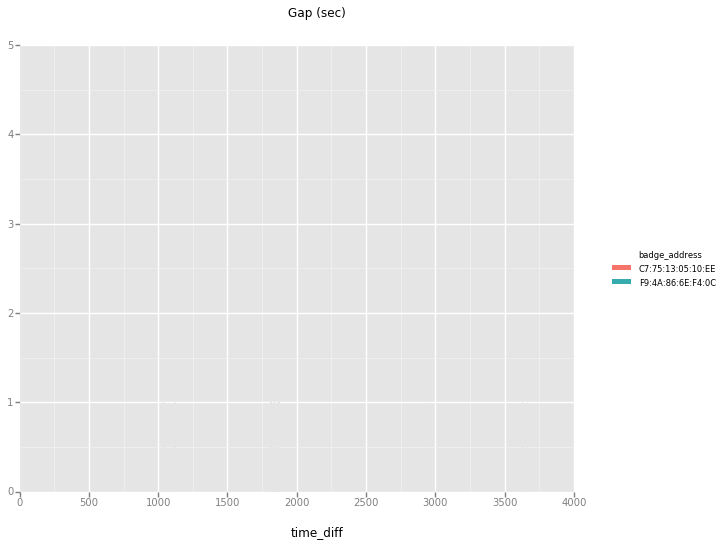

<ggplot: (8741660917853)>

In [20]:
p = ggplot(aes(x='time_diff', fill='badge_address'), data=gaps)
p + geom_histogram(binwidth=1)
p + geom_density(alpha=0.25) 
p + ggtitle("Gap (sec)")